In [2]:
import xarray as xr
from xmitgcm import open_mdsdataset
import xgcm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
import matplotlib.animation as animation
from fastjmd95 import rho
import sys
warnings.filterwarnings("ignore")

dsState = xr.open_dataset('TPOSE6_Hourly_Oct2012.nc',engine='netcdf4')

In [3]:
dudz = (dsState.UVEL[1:,:,:,:].values - dsState.UVEL[:-1,:,:,:].values)/(dsState.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-dsState.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])
dvdz = (dsState.VVEL[1:,:,:,:].values - dsState.VVEL[:-1,:,:,:].values)/(dsState.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-dsState.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])

tmp = dsState.UVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dudz
tmp.name = 'dudz'
tmp.attrs['units'] = '$s^{-1}$'
dudz = tmp 

tmp = dsState.VVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dvdz
tmp.name = 'dvdz'
tmp.attrs['units'] = '$s^{-1}$'
dvdz = tmp 

shear_2 = dudz**2 + dvdz**2

# ds.W_from_div_uv.plot()
sigma_0 = (rho(dsState.SALT, dsState.THETA, 0))
sigma_dz = (sigma_0[1:,:,:,:].values - sigma_0[:-1,:,:,:].values)/(dsState.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-dsState.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])

N2 = sigma_dz * (-9.8/1035) # this is the reference rho that ariane used for TPOSE6, check that this is still what we want (used for closing budgets)
N = (np.sqrt(N2) * 3600)/(2*np.pi) # this gives 1/hrs (assumed radians) need a /(2*np.pi) factor, convert  to cph

Ri = (N2/shear_2) # go back to doing 1/s2 for buoyancy so that it cancels the units correctly with shear squared (1/s2)

theta_anomaly = dsState.THETA - dsState.THETA.mean('time')
theta_anomaly.name = 'theta_anomaly'

tmp = dsState.VVEL[:-1,:,:,:].copy(deep=True)
tmp.values = N2
tmp.name = 'N2'
N2 = tmp 


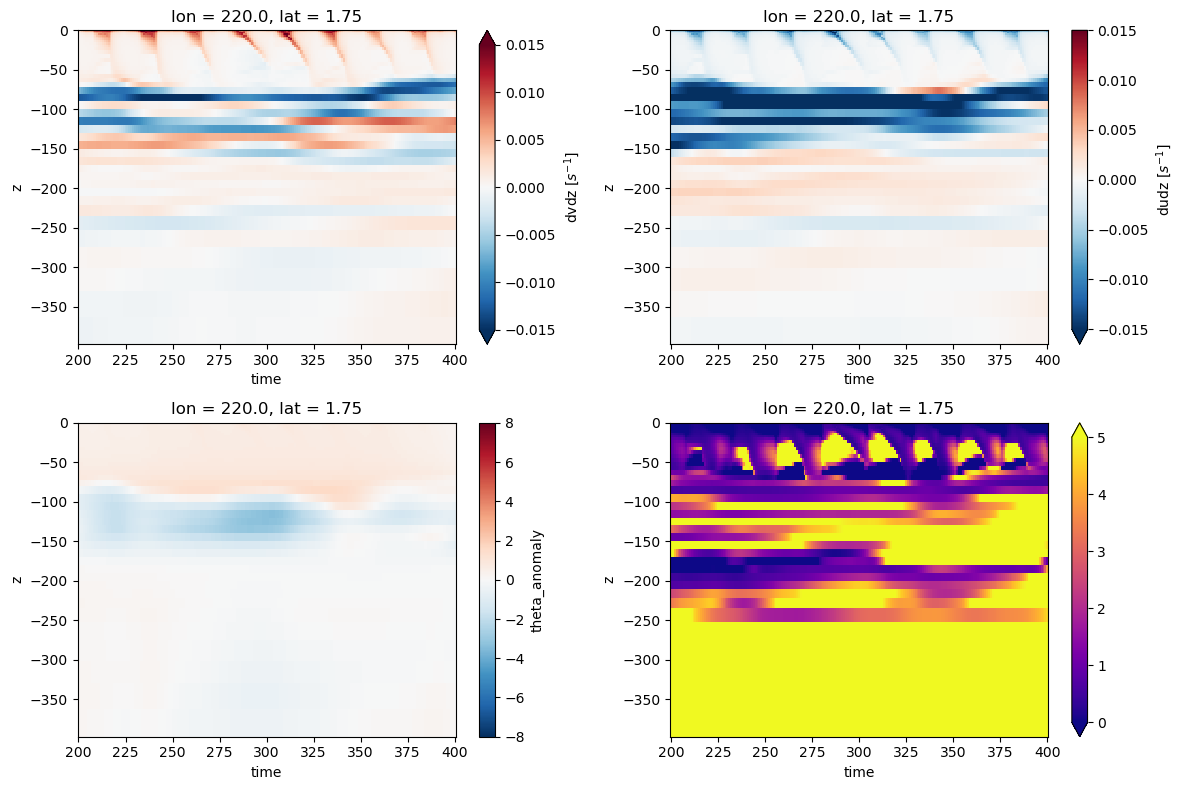

In [4]:
import cmocean as cmo
fig,ax = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
dvdz.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-400),time=slice(200,400)).plot(ax=ax[0,0],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
dudz.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-400),time=slice(200,400)).plot(ax=ax[0,1],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
theta_anomaly.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-400),time=slice(200,400)).plot(ax=ax[1,0],cmap='RdBu_r',vmin=-8,vmax=8)
Ri.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-400),time=slice(200,400)).plot(ax=ax[1,1],cmap='plasma',vmin=0,vmax=5)
plt.tight_layout()

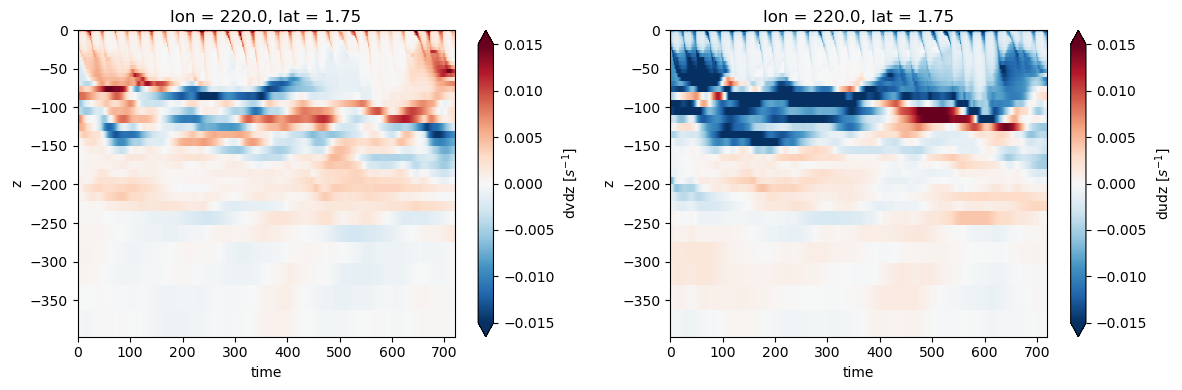

In [5]:
fig,ax = plt.subplots(figsize=(12,4),ncols=2)
dvdz.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[0],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
dudz.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[1],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
plt.tight_layout()

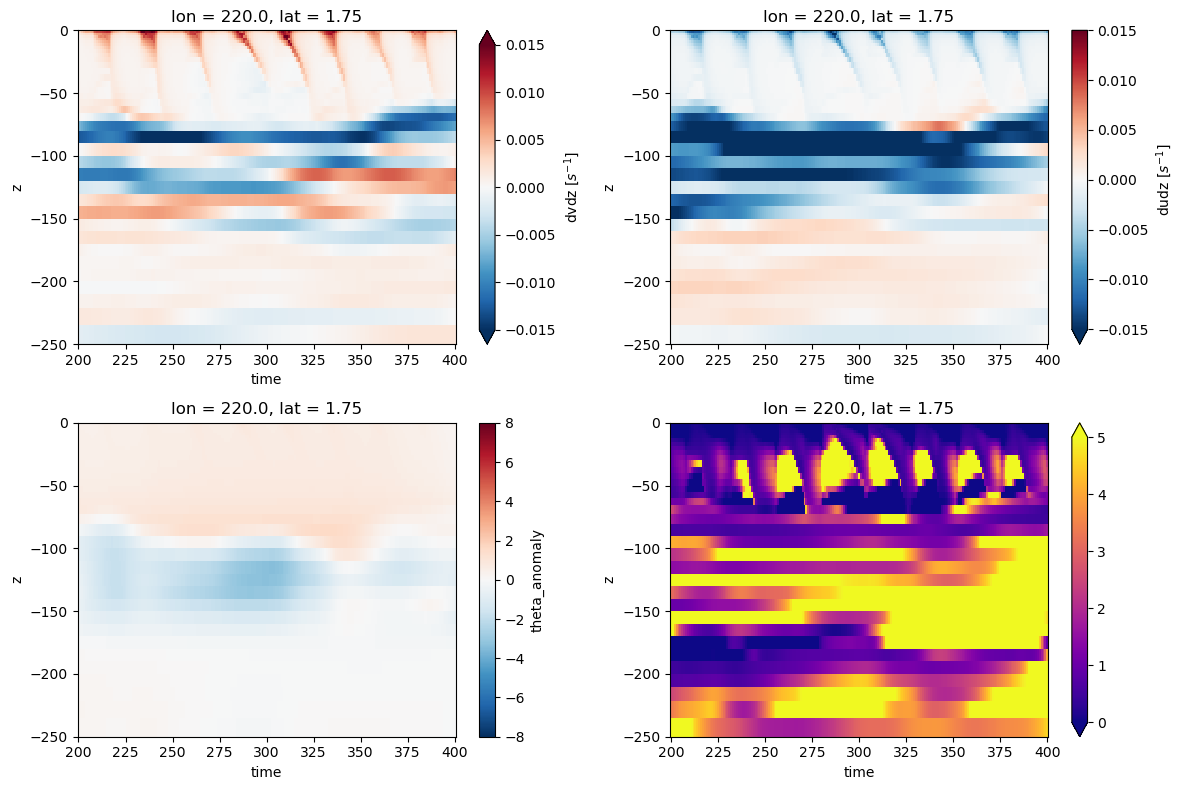

In [6]:
fig,ax = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
dvdz.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-250),time=slice(200,400)).plot(ax=ax[0,0],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
dudz.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-250),time=slice(200,400)).plot(ax=ax[0,1],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
theta_anomaly.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-250),time=slice(200,400)).plot(ax=ax[1,0],cmap='RdBu_r',vmin=-8,vmax=8)
Ri.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(0,-250),time=slice(200,400)).plot(ax=ax[1,1],cmap='plasma',vmin=0,vmax=5)
plt.tight_layout()

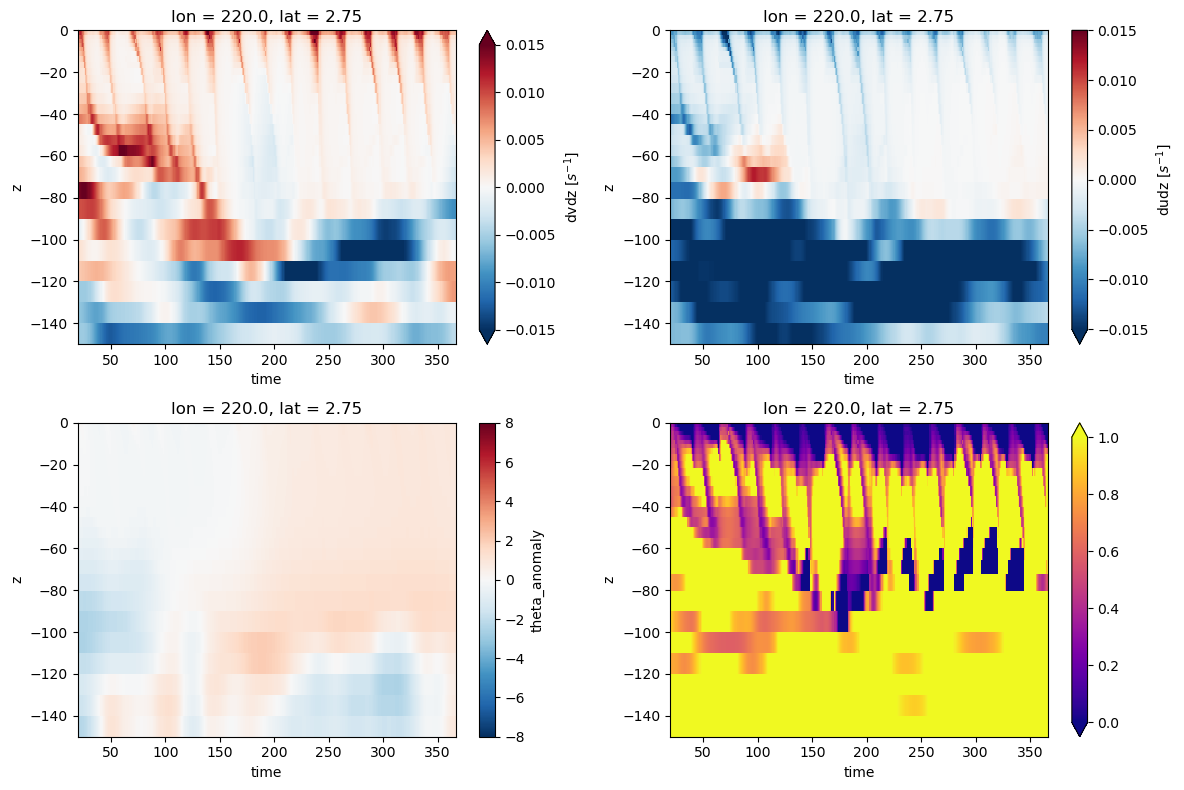

In [7]:
import cmocean as cmo
fig,ax = plt.subplots(figsize=(12,8),ncols=2,nrows=2)
dvdz.sel(lat=[2.75],lon=[220.0],method='nearest').sel(z=slice(0,-150),time=slice(20,366)).plot(ax=ax[0,0],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
dudz.sel(lat=[2.75],lon=[220.0],method='nearest').sel(z=slice(0,-150),time=slice(20,366)).plot(ax=ax[0,1],cmap='RdBu_r',vmin=-0.015,vmax=0.015)
theta_anomaly.sel(lat=[2.75],lon=[220.0],method='nearest').sel(z=slice(0,-150),time=slice(20,366)).plot(ax=ax[1,0],cmap='RdBu_r',vmin=-8,vmax=8)
Ri.sel(lat=[2.75],lon=[220.0],method='nearest').sel(z=slice(0,-150),time=slice(20,366)).plot(ax=ax[1,1],cmap='plasma',vmin=0,vmax=1)
plt.tight_layout()

Text(0.5, 0, '$S^2$')

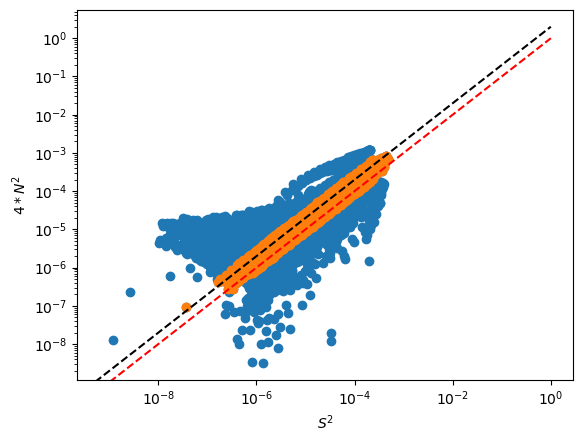

In [24]:
fig, ax = plt.subplots()
s2 = shear_2.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(30,-75),time=slice(200,700))
n2 = 4*N2.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(30,-75),time=slice(200,700))
ri = Ri.sel(lat=[1.75],lon=[220.0],method='nearest').sel(z=slice(30,-75),time=slice(200,700))

# Calculate quantiles
lower_quantile = ri.quantile(0.25)
upper_quantile = ri.quantile(0.75)
n2_filt = n2.where((ri >= lower_quantile) & (ri <= upper_quantile))
n2_25q = n2.where(ri <= lower_quantile)
n2_75q = n2.where(ri >= upper_quantile)
s2_filt = s2.where((ri >= lower_quantile) & (ri <= upper_quantile))
s2_25q = s2.where(ri <= lower_quantile)
s2_75q = s2.where(ri >= upper_quantile)

ax.scatter(s2,n2)
ax.scatter(s2_filt,n2_filt)
ax.semilogx()
ax.semilogy()
ax.plot([0, 1], [0, 1], color='red', linestyle='--')
ax.plot([0, 1], [0, 2], color='black', linestyle='--')
ax.set_ylabel('$4*N^2$')
ax.set_xlabel('$S^2$')


Text(0.5, 0, '$S^2$')

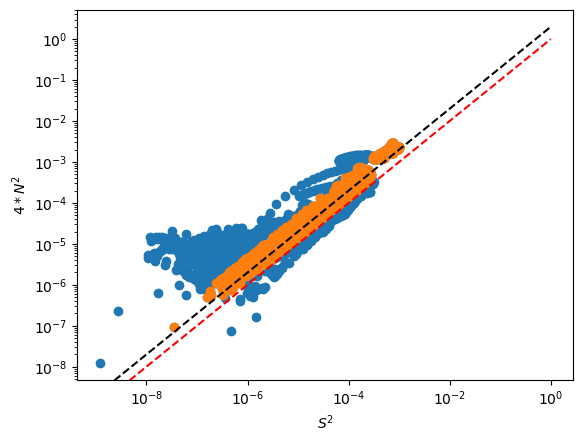

In [25]:
# subsample to 10m intervals - recompute
z_ind = np.array([9,11,13,15,17,19])+1
print(dsState.z[z_ind])

s2 = shear_2.sel(lat=[1.75],lon=[220.0],method='nearest').sel(time=slice(200,700)).isel(z=z_ind)
n2 = 4*N2.sel(lat=[1.75],lon=[220.0],method='nearest').sel(time=slice(200,700)).isel(z=z_ind)
ri = Ri.sel(lat=[1.75],lon=[220.0],method='nearest').sel(time=slice(200,700)).isel(z=z_ind)

# Calculate quantiles
lower_quantile = ri.quantile(0.25)
upper_quantile = ri.quantile(0.75)
n2_filt = n2.where((ri >= lower_quantile) & (ri <= upper_quantile))
n2_25q = n2.where(ri <= lower_quantile)
n2_75q = n2.where(ri >= upper_quantile)
s2_filt = s2.where((ri >= lower_quantile) & (ri <= upper_quantile))
s2_25q = s2.where(ri <= lower_quantile)
s2_75q = s2.where(ri >= upper_quantile)

fig, ax = plt.subplots()
ax.scatter(s2,n2)
ax.scatter(s2_filt,n2_filt)
ax.semilogx()
ax.semilogy()
ax.plot([0, 1], [0, 1], color='red', linestyle='--')
ax.plot([0, 1], [0, 2], color='black', linestyle='--')
ax.set_ylabel('$4*N^2$')
ax.set_xlabel('$S^2$')